In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Advanced Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor


In [19]:
df = pd.read_csv("Merged_dataset.csv")
df = df[df["Adsorbate IUPAC Formula"] != "C2 H2 O1"]

X = df[["Element", "Adsorbate Smiles", "h", "k", "l", "Surface Shift"]]
y = df["Adsorption Energy"]


In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), ["Element", "Adsorbate Smiles"]),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), ["h", "k", "l", "Surface Shift"])
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [21]:
# XGBoost
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42))
])

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
r2_xgb = r2_score(y_test, y_pred)

print("📊 XGBoost Performance")
print(f"MAE  : {mae_xgb:.4f}")
print(f"RMSE : {rmse_xgb:.4f}")
print(f"R²   : {r2_xgb:.4f}")


📊 XGBoost Performance
MAE  : 0.5538
RMSE : 0.9300
R²   : 0.8092


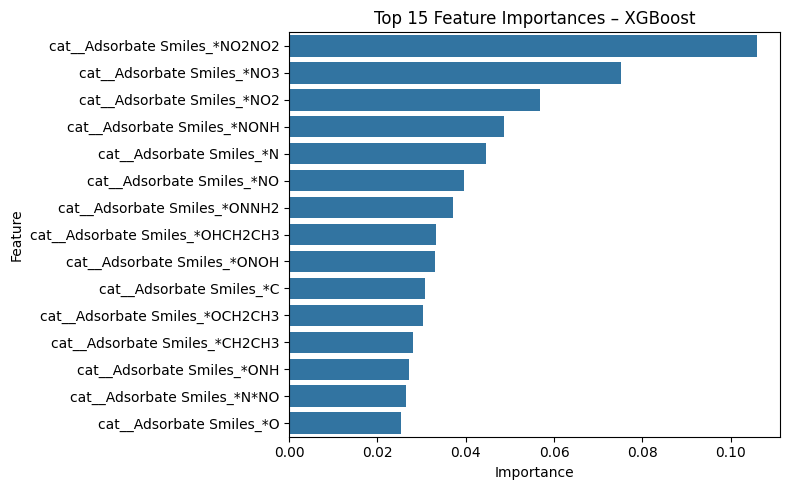

In [22]:
# Feature Importance (XGBoost)
best_xgb = xgb_model.named_steps["regressor"]

importances = best_xgb.feature_importances_
feature_names = xgb_model.named_steps["preprocessor"].get_feature_names_out()
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8, 5))
sns.barplot(y="Feature", x="Importance", data=feat_imp)
plt.title("Top 15 Feature Importances – XGBoost")
plt.tight_layout()
plt.show()


In [23]:
# LightGBM
lgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42))
])

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mae_lgb = mean_absolute_error(y_test, y_pred)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred))
r2_lgb = r2_score(y_test, y_pred)

print("📊 LightGBM Performance")
print(f"MAE  : {mae_lgb:.4f}")
print(f"RMSE : {rmse_lgb:.4f}")
print(f"R²   : {r2_lgb:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 42
[LightGBM] [Info] Start training from score -0.557015
📊 LightGBM Performance
MAE  : 1.0539
RMSE : 1.5600
R²   : 0.4630


c:\Users\ishan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [24]:
# CatBoost
cat_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", CatBoostRegressor(iterations=300, learning_rate=0.05, depth=6, verbose=0))
])

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mae_cat = mean_absolute_error(y_test, y_pred)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred))
r2_cat = r2_score(y_test, y_pred)

print("📊 CatBoost Performance")
print(f"MAE  : {mae_cat:.4f}")
print(f"RMSE : {rmse_cat:.4f}")
print(f"R²   : {r2_cat:.4f}")


📊 CatBoost Performance
MAE  : 0.6179
RMSE : 0.9530
R²   : 0.7996


In [25]:
# Neural Network
mlp_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42))
])

mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)

mae_mlp = mean_absolute_error(y_test, y_pred)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred))
r2_mlp = r2_score(y_test, y_pred)

print("📊 Neural Network (MLP) Performance")
print(f"MAE  : {mae_mlp:.4f}")
print(f"RMSE : {rmse_mlp:.4f}")
print(f"R²   : {r2_mlp:.4f}")


📊 Neural Network (MLP) Performance
MAE  : 0.6109
RMSE : 0.9738
R²   : 0.7908


,Model,MAE,RMSE
0,XGBoost,0.553792,0.929966
1,LightGBM,1.053940,1.560033
2,CatBoost,0.617911,0.953003
3,Neural Network,0.610863,0.973827


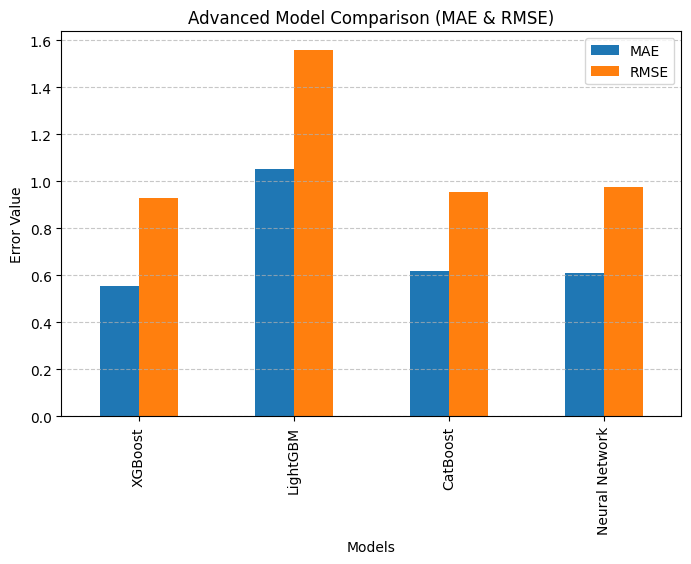

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Manual entry of results
results = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost", "Neural Network"],
    "MAE": [0.553792, 1.053940, 0.617911, 0.610863],
    "RMSE": [0.929966, 1.560033, 0.953003, 0.973827]
})

# Display the DataFrame
display(results)

# Plot comparison
results.set_index("Model")[["MAE", "RMSE"]].plot(
    kind="bar", figsize=(8,5), title="Advanced Model Comparison (MAE & RMSE)", legend=True
)
plt.xlabel("Models")
plt.ylabel("Error Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


,Model,R²
0,XGBoost,0.809
1,LightGBM,0.463
2,CatBoost,0.799
3,Neural Network,0.791


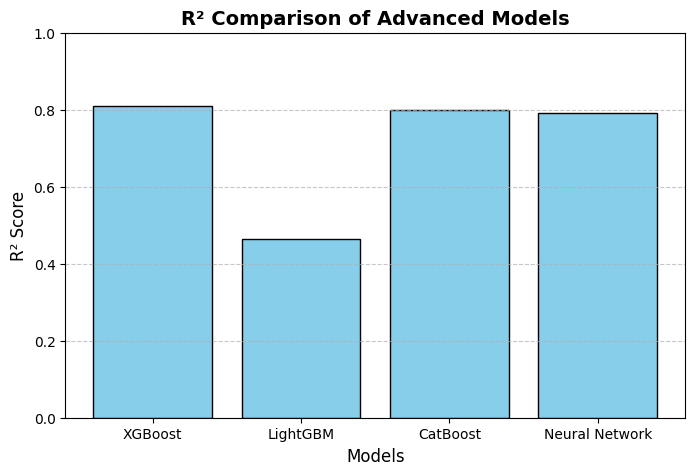

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Manually enter your R² scores here
r2_results = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost", "Neural Network"],
    "R²": [0.809, 0.463, 0.799, 0.791]  # ← replace with your actual values
})

# Display table
display(r2_results)

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(r2_results["Model"], r2_results["R²"], color="skyblue", edgecolor="black")
plt.title("R² Comparison of Advanced Models", fontsize=14, weight="bold")
plt.ylabel("R² Score", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate values on top of bars


plt.show()


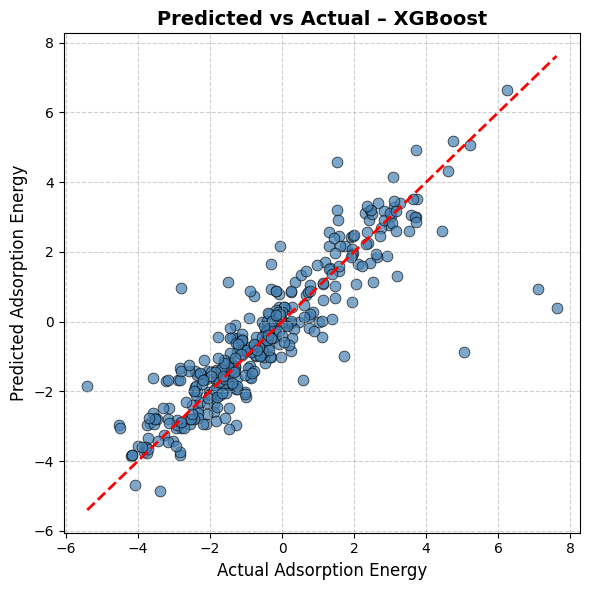

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: replace y_test and y_pred with your actual test and prediction arrays
# y_test = ...
# y_pred = ...

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, color='steelblue', s=60, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Adsorption Energy", fontsize=12)
plt.ylabel("Predicted Adsorption Energy", fontsize=12)
plt.title("Predicted vs Actual – XGBoost", fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
